<a href="https://colab.research.google.com/github/geraschenko/CME241/blob/main/assignments_raw/assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stanford CME 241 (Winter 2024) - Assignment 7

**Due: Mar 4 @ 11:59pm Pacific Time on Gradescope (after the exam).**

Assignment instructions:
- **Solve all 3 questions.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):*

https://github.com/my-username/my-repo/assignment-file-name.ipynb

*Group members (replace below names with people in your group):*
- Person 1
- Person 2
- Person 3

## Imports

In [ ]:
!pip install -q git+https://github.com/TikhonJelvis/RL-book.git

  Preparing metadata (setup.py) ... done


In [ ]:
!git clone https://github.com/TikhonJelvis/RL-book.git rl_book

fatal: destination path 'rl_book' already exists and is not an empty directory.


In [ ]:
from dataclasses import dataclass
from typing import Callable, Iterator, Mapping
import itertools
import matplotlib.pyplot as plt
import numpy as np
import rl

In [ ]:
from rl_book.rl.chapter10 import prediction_utils

## Question 1
In the following question, we explore the connection between TD and MC
algorithms.

1.  Implement the TD($\lambda$) Prediction algorithm from scratch in
Python code. First do it for the Tabular case, then do it for the
case of Function Approximation.

2.  Prove that the MC Error can be written as the sum of discounted TD errors, i.e.,
$$G_t - V(S_t) = \sum_{u=t}^{T-1} \gamma^{u-t} \cdot (R_{u+1} + \gamma \cdot V(S_{u+1}) - V(S_u))$$
The goal here is for you to practice formal proof-writing of these
types of simple yet important identities. So aim to work this out
from scratch rather than treating this as a special case of a more
general result proved in class or in the textbook.

3.  Test your above implementation of TD($\lambda$) Prediction algorithm
by comparing the Value Function of an MRP you have previously
developed (or worked with) as obtained by Policy Evaluation (DP)
algorithm, as obtained by MC, as obtained by TD, and as obtained by
your TD($\lambda$) implementation. Plot graphs of convergence for
different values of $\lambda$.

4.  Extend `RandomWalkMRP` (in
[rl/chapter10/random_walk_mrp.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter10/random_walk_mrp.py))
to `RandomWalkMRP2D` which is a random walk in 2-D with states
$\{i, j) | 0 \leq i \leq B_1, 0 \leq j \leq B_2\}$ with terminal
states as $(0, j)$ and $(B_1, j)$ for all $j$, $(i, 0)$ and
$(i, B_2)$ for all $i$, and with reward of 0 for all $(0, j)$ and
for all $(i, 0)$, reward of 1 for all $(B_1, j)$ and for all
$(i, B_2)$, and with discrete probabilities of 4 movements - UP,
DOWN, LEFT, RIGHT from any non-terminal state. Analyze the
convergence of MC and TD on this `RandomWalkMRP2D` much like how we
analyzed it for `RandomWalkMRP`, along with plots of similar graphs.

In [ ]:
# TODO: implement TD(lambda) from scratch.

---
We prove that
$$G_t - V(S_t) = \sum_{u=t}^{T-1} \gamma^{u-t} \cdot (R_{u+1} + \gamma \cdot V(S_{u+1}) - V(S_u))$$
by induction on $T - t$, where $T$ is the terminating time. Letting $V$ denote the value function extended to terminal states by 0, we can take $t = T$ as the base case: $G_T - V(S_T) = G_T = 0$ (the empty sum is also $0$).

For the inductive step, we have
$$\begin{align*}
G_t - V(S_t) &= R_{t+1} + \gamma G_{t+1} - V(S_t)\\
  &= R_{t+1} + \gamma V(S_{t+1}) - V(S_t) + \gamma(G_{t+1} - V_{t+1}) \\
  &= R_{t+1} + \gamma V(S_{t+1}) - V(S_t) + \gamma\sum_{u=t+1}^{T-1} \gamma^{u-t-1} \cdot (R_{u+1} + \gamma \cdot V(S_{u+1}) - V(S_u)) \\
  &= \sum_{u=t}^{T-1} \gamma^{u-t} \cdot (R_{u+1} + \gamma \cdot V(S_{u+1}) - V(S_u))
\end{align*}$$
where the second to last equality is by the inductive hypothesis.


In [ ]:
from rl.distribution import Categorical
from rl.markov_process import FiniteMarkovRewardProcess

RWState = tuple[int, int]

@dataclass
class RandomWalkMRP2D(FiniteMarkovRewardProcess[RWState]):
  barrier: tuple[int, int]
  p: list[float]  # indexed UP, DOWN, LEFT, RIGHT

  def __post_init__(self):
    super().__init__(self.get_transition_map())

  def get_transition_map(self) -> Mapping[RWState, Categorical[tuple[RWState, float]]]:
    return {
        i: Categorical({
            ((i, j + 1), 0. if j < self.barrier[1] - 1 else 1.): self.p[0],
            ((i, j - 1), 0.): self.p[1],
            ((i + 1, j), 0. if i < self.barrier[0] - 1 else 1.): self.p[2],
            ((i - 1, j), 0. ): self.p[3]
        })
        for i in range(1, self.barrier[0])
        for j in range(1, self.barrier[1])
    }

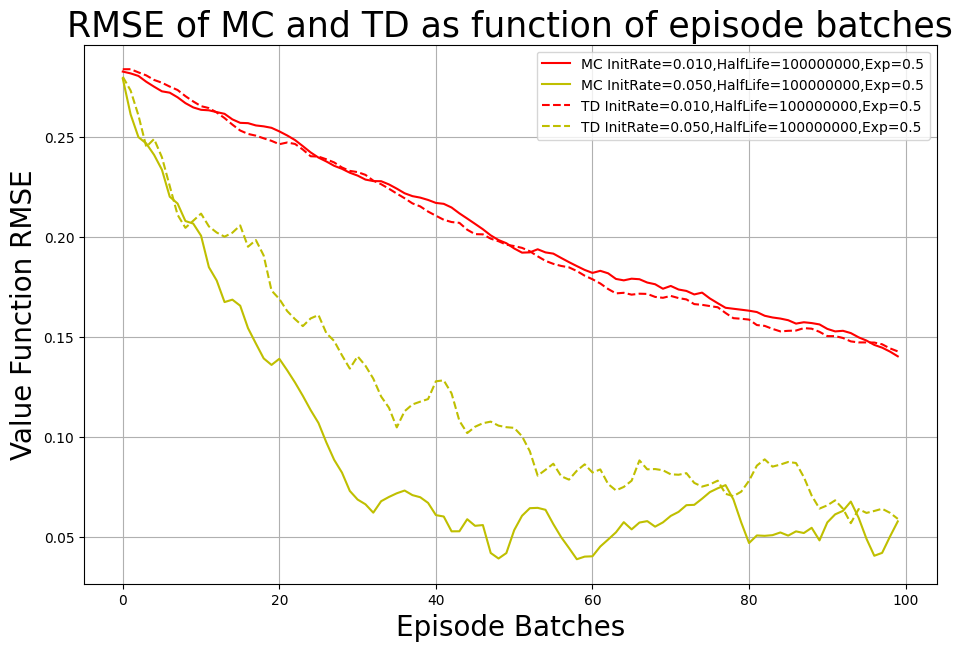

In [ ]:
from rl_book.rl.chapter10.prediction_utils import compare_td_and_mc

barrier = 10, 7
p = [0.2, .4, .3, .1]
random_walk = RandomWalkMRP2D(barrier, p)
compare_td_and_mc(
    fmrp=random_walk,
    gamma=1.0,
    mc_episode_length_tol=1e-6,
    num_episodes=700,
    learning_rates=[(0.01, 1e8, 0.5), (0.05, 1e8, 0.5)],
    initial_vf_dict={s: 0.5 for s in random_walk.non_terminal_states},
    plot_batch=7,
    plot_start=0
)

## Question 2
In this question, we will explore three different algorithms for control
based on MC or TD. Please complete 2 of the following 3 implementations.
For each algorithm, we expect you to test your implementation against
the Optimal Value Function/Optimal Policy obtained by DP on
`SimpleInventoryMDPCap` in
[rl/chapter3/simple_inventory_mdp_cap.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter3/simple_inventory_mdp_cap.py).
Then, generalize to MC Control with Function approximation and test your
implementation against the Optimal Value Function/Optimal Policy
obtained by ADP on `AssetAllocDiscrete` in
[rl/chapter7/asset_alloc_discrete.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter7/asset_alloc_discrete.py).

1.  Implement Tabular Monte-Carlo Control algorithm in Python with GLIE implemented as $\epsilon = \frac 1 k$ for episode number $k$ and initial state of each episode sampled uniformly from the state
space.

2.  Implement Tabular SARSA algorithm in Python with GLIE and a parameterized trajectory of decreasing step sizes.

3.  Implement Tabular Q-Learning algorithm in Python with infinite
exploration of all (state, action) pairs and with a parameterized
trajectory of decreasing step sizes.

## Question 3
Finally, we will explore reinforcment learning algorithms and apply them
to the problem of Amercian options pricing. Implement the following two
algorithms and apply them to the problem of American Options Pricing, as
covered in class. Test by comparing the pricing of American Calls and
Puts against the Binomial Tree implmeentation in
[rl/chapter8/optimal_exercise_bin_tree.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter8/optimal_exercise_bin_tree.py).

1.  LSPI

2.  Deep Q-Learning